<h3>Movie Recommendation using Collaborative Filtering</h3>

Also known as User-User Filtering. 

The input user is given recommendations for things by other users. It looks for users whose tastes and viewpoints are similar to the input, then suggests goods that these users have found appealing to the input. The technique we'll be utilizing here is based on the Pearson Correlation Function, but there are other ways to identify comparable users as well (some even employ machine learning).

In [103]:
import numpy as np 
import pandas as pd 

In [104]:
from math import sqrt
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Reading the datasets that we have. We will need movies and the ratings files. 

In [105]:
movie = pd.read_csv('ml-1m/movies.csv')
rating= pd.read_csv('ml-1m/ratings.csv')

About the dataset

In [106]:
# Number of users
print('The ratings dataset has', rating['UserID'].nunique(), 'unique users')

# Number of movies
print('The ratings dataset has', rating['MovieID'].nunique(), 'unique movies')

# Number of ratings
print('The ratings dataset has', rating['Rating'].nunique(), 'unique ratings')

# List of unique ratings
print('The unique ratings are', sorted(rating['Rating'].unique()))

The ratings dataset has 6040 unique users
The ratings dataset has 3706 unique movies
The ratings dataset has 5 unique ratings
The unique ratings are [1, 2, 3, 4, 5]


In [107]:
no_user_voted = rating.groupby('MovieID')['Rating'].agg('count')
no_movies_voted = rating.groupby('UserID')['Rating'].agg('count')

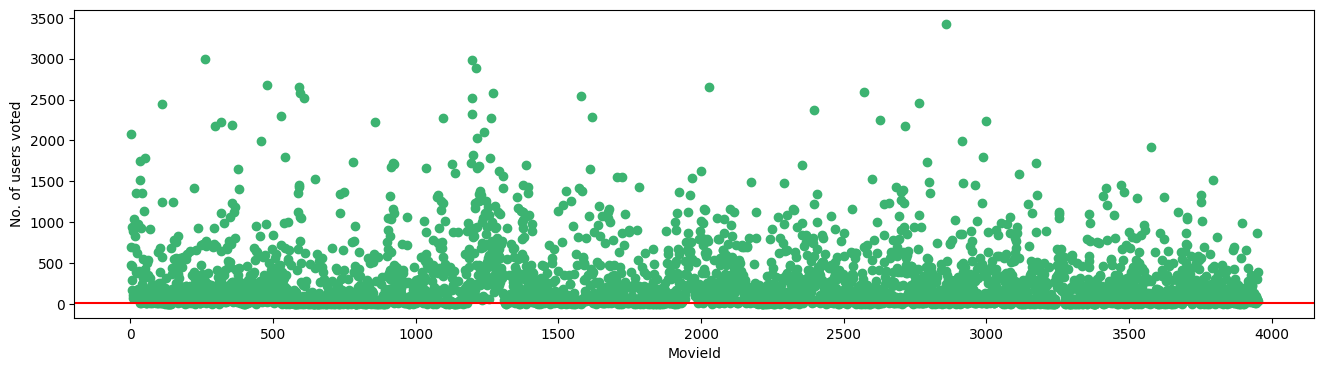

In [108]:
import matplotlib.pyplot as plt
f,ax = plt.subplots(1,1,figsize=(16,4))
# ratings['rating'].plot(kind='hist')
plt.scatter(no_user_voted.index,no_user_voted,color='mediumseagreen')
plt.axhline(y=10,color='r')
plt.xlabel('MovieId')
plt.ylabel('No. of users voted')
plt.show()

Quick view of the two dataframes, the rows and the columns

In [109]:
movie.head()

,ID,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [110]:
rating

,UserID,MovieID,Rating,Timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291
...,...,...,...,...
1000204,6040,1091,1,956716541
1000205,6040,1094,5,956704887
1000206,6040,562,5,956704746
1000207,6040,1096,4,956715648


Removing year from the title

In [111]:
def remove_year(title_with_year):
    # Split the title based on parentheses
    parts = title_with_year.split('(')
    
    # Take the first part which is the actual title
    title = parts[0].strip()
    
    return title

In [112]:
movie

,ID,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
3878,3948,Meet the Parents (2000),Comedy
3879,3949,Requiem for a Dream (2000),Drama
3880,3950,Tigerland (2000),Drama
3881,3951,Two Family House (2000),Drama


Now removing the year from the title in the Title column. 

In [113]:
for index, row in movie.iterrows():
    movie.at[index, 'Title'] = remove_year(movie.at[index, 'Title'])

In [114]:
movie.head()

,ID,Title,Genres
0,1,Toy Story,Animation|Children's|Comedy
1,2,Jumanji,Adventure|Children's|Fantasy
2,3,Grumpier Old Men,Comedy|Romance
3,4,Waiting to Exhale,Comedy|Drama
4,5,Father of the Bride Part II,Comedy


Collaborative filtering doesn't recommend based on the features of the movie. The recommendation is based on the likes and dislikes or ratings of the neighbours or other users. 
So we will drop the genre column, since there is no use of it. 

In [115]:
movie.drop(columns=['Genres'], inplace=True)

In [116]:
movie.head()

,ID,Title
0,1,Toy Story
1,2,Jumanji
2,3,Grumpier Old Men
3,4,Waiting to Exhale
4,5,Father of the Bride Part II


Now, coming to the ratings dataframe, we have the movieId column that is common with the movie dataframe. Each user has given multiple ratings for different movies. The column Timestamp is not needed for the recommendation system. So we can drop it. 

In [117]:
rating.drop(columns=['Timestamp'],inplace=True)

In [118]:
rating.head()

,UserID,MovieID,Rating
0,1,1193,5
1,1,661,3
2,1,914,3
3,1,3408,4
4,1,2355,5


In [119]:
# # Aggregate by movie
# agg_ratings = rating.groupby('MovieID').agg(mean_rating = ('Rating', 'mean'),
#                                                 number_of_ratings = ('Rating', 'count')).reset_index()

# # Keep the movies with over 100 ratings
# agg_ratings_GT100 = agg_ratings[agg_ratings['number_of_ratings']>400]
# agg_ratings_GT100.info()

In [120]:
# Check popular movies
# agg_ratings_GT100.sort_values(by='number_of_ratings', ascending=False).head()

In [121]:
# agg_ratings_GT100

In [122]:
# Visulization
# sns.jointplot(x='mean_rating', y='number_of_ratings', data=agg_ratings_GT100)

The technique is called Collaborative Filtering, which is also known as User-User Filtering. As hinted by its alternate name, this technique uses other users to recommend items to the input user. It attempts to find users that have similar preferences and opinions as the input and then recommends items that they have liked to the input. There are several methods of finding similar users (Even some making use of Machine Learning), and the one we will be using here is going to be based on the Pearson Correlation Function.

The process for creating a User Based recommendation system is as follows:
- Select a user with the movies the user has watched
- Based on his rating to movies, find the top X neighbours 
- Get the watched movie record of the user for each neighbour.
- Calculate a similarity score using some formula
- Recommend the items with the highest score

In [123]:
user = [
            {'Title':'Toy Story', 'Rating':4},
            {'Title':'Toy Story 2', 'Rating': 5},
            {'Title':'Seven', 'Rating':5},
            {'Title':'Romeo and Juliet', 'Rating': 3},
            {'Title':'Home Alone', 'Rating': 3}
         ] 
inputMovie = pd.DataFrame(user)
inputMovie

,Title,Rating
0,Toy Story,4
1,Toy Story 2,5
2,Seven,5
3,Romeo and Juliet,3
4,Home Alone,3


We need to now add the movieId column from the movie dataframe into the inputMovie Dataframe. 
First filter out the rows that contain the input movies' title and then merging this subset with the input dataframe. We also drop unnecessary columns for the input to save memory space.

In [124]:
#Filtering out the movies by title
Id = movie[movie['Title'].isin(inputMovie['Title'].tolist())]
#Then merging it so we can get the movieId. It's implicitly merging it by title.
Id

,ID,Title
0,1,Toy Story
46,47,Seven
582,586,Home Alone
3045,3114,Toy Story 2
3599,3668,Romeo and Juliet


In [125]:
inputMovie = pd.merge(Id, inputMovie)
#Dropping information we won't use from the input dataframe
# inputMovie = inputMovie.drop('year', 1)
inputMovie

,ID,Title,Rating
0,1,Toy Story,4
1,47,Seven,5
2,586,Home Alone,3
3,3114,Toy Story 2,5
4,3668,Romeo and Juliet,3


**Finding the users who have seen the same movies from the rating dataframe**
With the movie ID's in our input, we can now get the subset of users that have watched and reviewed the movies in our input.

In [126]:
#Filtering out users that have watched movies that the input has watched and storing it
users = rating[rating['MovieID'].isin(inputMovie['ID'].tolist())]
users.head()

,UserID,MovieID,Rating
40,1,1,5
50,1,3114,4
203,3,3114,3
283,5,47,3
469,6,1,4


In [127]:
users.shape

(5830, 3)

In [128]:
#Groupby creates several sub dataframes where they all have the same value in the column specified as the parameter
userSubsetGroup = users.groupby(['UserID'])

In [129]:
#Sorting it so users with movie most in common with the input will have priority
userSubsetGroup = sorted(userSubsetGroup,  key=lambda x: len(x[1]), reverse=True)

In [130]:
userSubsetGroup

[((273,),
         UserID  MovieID  Rating
  40638     273      586       2
  40642     273        1       5
  40666     273     3114       5
  40774     273       47       4
  40780     273     3668       2),
 ((302,),
         UserID  MovieID  Rating
  44129     302      586       3
  44132     302        1       4
  44227     302     3114       4
  44715     302       47       5
  44748     302     3668       3),
 ((531,),
         UserID  MovieID  Rating
  79013     531      586       4
  79017     531        1       5
  79340     531     3668       3
  79448     531     3114       5
  79745     531       47       4),
 ((752,),
          UserID  MovieID  Rating
  115747     752      586       2
  115750     752        1       5
  116128     752     3668       2
  116264     752     3114       5
  116607     752       47       2),
 ((855,),
          UserID  MovieID  Rating
  132187     855      586       3
  132191     855        1       4
  132415     855     3668       3
  132506

In [131]:
def convert_tuple_format(tuple_list):
    converted_list = []
    for tup in tuple_list:
        converted_tup = tuple(map(lambda x: x[0] if isinstance(x, tuple) and len(x) == 1 else x, tup))
        converted_list.append(converted_tup)
    return converted_list

In [132]:
userSubsetGroup = convert_tuple_format(userSubsetGroup)
# userSubsetGroup

**Similarity of users to input user**
Next, we are going to compare all users  to our specified user and find the one that is most similar.
we're going to find out how similar each user is to the input through the Pearson Correlation Coefficient. It is used to measure the strength of a linear association between two variables. The formula for finding this coefficient between sets X and Y with N values can be seen in the image below.

Why Pearson Correlation?

Pearson correlation is invariant to scaling, i.e. multiplying all elements by a nonzero constant or adding any constant to all elements. For example, if you have two vectors X and Y,then, pearson(X, Y) == pearson(X, 2 * Y + 3). This is a pretty important property in recommendation systems because for example two users might rate two series of items totally different in terms of absolute rates, but they would be similar users (i.e. with similar ideas) with similar rates in various scales .

![alt text](https://wikimedia.org/api/rest_v1/media/math/render/svg/bd1ccc2979b0fd1c1aec96e386f686ae874f9ec0 "Pearson Correlation") 

The values given by the formula vary from r = -1 to r = 1, where 1 forms a direct correlation between the two entities (it means a perfect positive correlation) and -1 forms a perfect negative correlation.

In our case, a 1 means that the two users have similar tastes while a -1 means the opposite.

In [133]:
userSubsetGroup = userSubsetGroup[0:100]

##### The function iterates over each user group, sorts their ratings, computes the correlation with the input user, and stores the result in a dictionary.

In [134]:
#Store the Pearson Correlation in a dictionary, where the key is the user Id and the value is the coefficient
pearsonCorDict = {}

#For every user group in our subset
for name, group in userSubsetGroup:
    #Let's start by sorting the input and current user group so the values aren't mixed up later on
    group = group.sort_values(by='MovieID')
    inputMovie = inputMovie.sort_values(by='ID')
    #Get the N for the formula
    n = len(group)
    #Get the review scores for the movies that they both have in common
    temp = inputMovie[inputMovie['ID'].isin(group['MovieID'].tolist())]
    #And then store them in a temporary buffer variable in a list format to facilitate future calculations
    tempRatingList = temp['Rating'].tolist()
    #put the current user group reviews in a list format
    tempGroupList = group['Rating'].tolist()
    #Now let's calculate the pearson correlation between two users, so called, x and y
    Sxx = sum([i**2 for i in tempRatingList]) - pow(sum(tempRatingList),2)/float(n)
    Syy = sum([i**2 for i in tempGroupList]) - pow(sum(tempGroupList),2)/float(n)
    Sxy = sum( i*j for i, j in zip(tempRatingList, tempGroupList)) - sum(tempRatingList)*sum(tempGroupList)/float(n)
    
    #If the denominator is different than zero, then divide, else, 0 correlation.
    if Sxx != 0 and Syy != 0:
        pearsonCorDict[name] = Sxy/sqrt(Sxx*Syy)
    else:
        pearsonCorDict[name] = 0


In [135]:
pearsonCorDict.items()

dict_items([(273, 0.8242255917447335), (302, 0.8964214570007957), (531, 0.5976143046671971), (752, 0.45643546458763845), (855, 0.9128709291752758), (1088, 0.5590169943749485), (1112, 0.5976143046671971), (1150, 0.2988071523335984), (1181, 0.5590169943749485), (1383, 0.7071067811865475), (1422, 0.0), (1447, 0.4564354645876379), (1451, 0.8964214570007957), (1605, 0.9128709291752758), (1635, 0.5590169943749473), (1880, 0.5976143046671971), (1899, 0.45643546458763856), (1912, 0.38348249442368526), (2023, 0.7669649888473705), (2063, 0.32969023669789344), (2106, 0.5590169943749485), (2109, 0), (2116, 0.8385254915624207), (2223, 0.18633899812498245), (2529, 0.5590169943749485), (2810, 0.29880715233359856), (2887, 0.35355339059327373), (2888, 0.0), (3032, -0.4564354645876379), (3391, 0.5590169943749485), (3509, 0.0), (3648, 0.877058019307029), (3792, 0.8242255917447335), (3821, 0.35355339059327373), (4344, 0.3042903097250923), (4387, -0.29880715233359856), (4543, 0.6123724356957946), (4579, 0.

In [136]:
pearsonDF = pd.DataFrame.from_dict(pearsonCorDict, orient='index')
pearsonDF.columns = ['similarityIndex']
pearsonDF['UserID'] = pearsonDF.index
pearsonDF.index = range(len(pearsonDF))

topUsers=pearsonDF.sort_values(by='similarityIndex', ascending=False)[0:100]
topUsers.head()


,similarityIndex,UserID
4,0.912871,855
13,0.912871,1605
64,0.904534,637
63,0.899229,631
44,0.896421,6016


**Rating of selected users to all movies**
We're going to do this by taking the weighted average of the ratings of the movies using the Pearson Correlation as the weight. But to do this, we first need to get the movies watched by the users in our pearsonDF from the ratings dataframe and then store their correlation in a new column called _similarityIndex". This is achieved below by merging of these two tables.

In [137]:
topUsersRating=topUsers.merge(rating, left_on='UserID', right_on='UserID', how='inner')
topUsersRating.head()

,similarityIndex,UserID,MovieID,Rating
0,0.912871,855,2987,3
1,0.912871,855,1249,4
2,0.912871,855,574,3
3,0.912871,855,577,3
4,0.912871,855,2052,2


multiply the movie rating by its weight (The similarity index), then sum up the new ratings and divide it by the sum of the weights.

We can easily do this by simply multiplying two columns, then grouping up the dataframe by movieId and then dividing two columns:

In [138]:
#Multiplies the similarity by the user's ratings
topUsersRating['weightedRating'] = topUsersRating['similarityIndex']*topUsersRating['Rating']
topUsersRating.head()

,similarityIndex,UserID,MovieID,Rating,weightedRating
0,0.912871,855,2987,3,2.738613
1,0.912871,855,1249,4,3.651484
2,0.912871,855,574,3,2.738613
3,0.912871,855,577,3,2.738613
4,0.912871,855,2052,2,1.825742


In [139]:
#Applies a sum to the topUsers after grouping it up by userId
tempTopUsersRating = topUsersRating.groupby('MovieID').sum()[['similarityIndex','weightedRating']]
tempTopUsersRating.columns = ['sum_similarityIndex','sum_weightedRating']
tempTopUsersRating.head()

,sum_similarityIndex,sum_weightedRating
MovieID,,
1,43.854875,199.766108
2,26.309814,82.409634
3,20.912685,63.924624
4,8.442900,20.506214
5,15.803338,49.952793


In [140]:
#Creates an empty dataframe
recommendation_df = pd.DataFrame()
#Now we take the weighted average
recommendation_df['weighted average recommendation score'] = tempTopUsersRating['sum_weightedRating']/tempTopUsersRating['sum_similarityIndex']
recommendation_df['MovieID'] = tempTopUsersRating.index
recommendation_df.head()

,weighted average recommendation score,MovieID
MovieID,,
1,4.555163,1
2,3.132277,2
3,3.056739,3
4,2.428812,4
5,3.160901,5


In [141]:
recommendation_df = recommendation_df.sort_values(by='weighted average recommendation score', ascending=False)
recommendation_df.head(5)

,weighted average recommendation score,MovieID
MovieID,,
3645,336.493243,3645
2493,101.744230,2493
2632,34.789749,2632
2824,14.833533,2824
3808,14.263250,3808


In [142]:
recomm_movies = []
for movId in recommendation_df['MovieID']:
    movie_name = movie.loc[movie['ID'] == movId, 'Title'].values[0]
    recomm_movies.append(movie_name)
    

### Top 5 Recommended Movies

In [143]:
recomm_movies[0:5]

['Cleo From 5 to 7',
 'Harmonists, The',
 'Saragossa Manuscript, The',
 'On the Ropes',
 'Two Women']